In [15]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler



In [16]:
subject_dict= {'A': 'Manuals', 'B': 'Italian Art', 'C': 'Italian Artists', 'D': 'Rome','E':'Italian Topography', 'F': 'Travel Literature', 
               'G': 'Sources', 'H': 'Iconography', 'J': 'Ornament','Kat': 'Catalogues','K': 'Commemorative and Collected Writings','L': 'Congress Publications', 'M': 'Art in General',
                'N': 'Architecture', 'O':'Sculpture','Per': 'Periodicals', 'P': 'Painting', 'Q': 'Manuscript Illumination', 'R': 'Graphic Arts', 
               'S': 'Applied Arts', 'T': 'Collecting Art, Museum Studies', 'U': 'Registers of Artistic Monuments', 'V': 'Cultural Institutions', 
               'W': 'Non-Italian Artists','X': 'European Topography', 'Y': 'World Topography', 'Z': 'Related Disciplines'}

custom_colours = [
    "#EA522B", "#EFD4D1", "#2A4978", "#8BDBE1", "#ECA19D", "#B48E36", "#EB84D6", "#B8BFCE", "#FAC73B", "#91C5E4",
    "#6E8EAC", "#D2E7E0","#DAA47F", "#ECD096", "#6C9686", "#E6E10F", "#9D4B37", "#A3B49D", "#BDC920", "#DBE3E5", "#6A8B8D",
    "#EFB3D1", "#F6A1B4", "#5499C7", "#1C2833", "#F0B27A", "#2E7F7F", "#CB4335", "#4A235A"
]

custom_cmap = ListedColormap(custom_colours)

def get_subject(call_number):
    for key, category in subject_dict.items():
        if call_number.startswith(key):
            return category
    return 'Unknown'

# User data

 

In [17]:
user_df = pd.DataFrame()

csv_directory = '../user_data'

for filename in os.listdir(csv_directory):
    if filename.endswith(".csv"):
        year = filename.split('.')[0]
        file_path = os.path.join(csv_directory, filename)
        df = pd.read_csv(file_path, delimiter=';',encoding='ISO-8859-1',low_memory=False)
        user_df = pd.concat([user_df, df], ignore_index=True)

# To datetime
user_df['Z36H_LOAN_DATE'] = pd.to_datetime(user_df['Z36H_LOAN_DATE'], format='%Y%m%d', errors='coerce')
user_df['Z36H_RETURNED_DATE'] = pd.to_datetime(user_df['Z36H_RETURNED_DATE'], format='%Y%m%d', errors='coerce')
user_df.dropna(subset=['Z36H_LOAN_DATE'], inplace=True)
user_df['Year'] = user_df['Z36H_LOAN_DATE'].dt.year

# Clean up 2014
mask = user_df['Year'] == 2014
user_df.loc[mask, 'Z30_CALL_NO'] = user_df.loc[mask, 'ï»¿Z30_CALL_NO']
user_df = user_df.drop('ï»¿Z30_CALL_NO', axis=1)

# Drop 2012
user_df = user_df[user_df.Year != 2012]

# Calculate Loan time per day
user_df['LOAN_TIME'] = (user_df['Z36H_RETURNED_DATE'] - user_df['Z36H_LOAN_DATE']).dt.days + 1 # min loan time is 1
print('No return date: {}'.format(user_df.Z36H_RETURNED_DATE.isna().sum()))
user_df = user_df.dropna(subset=['Z36H_RETURNED_DATE'])

# Pseudonymise the users 
    
unique_users = user_df['Z36H_ID'].unique()
user_pseudonyms = {user: f'U-{index}'  for index, user in enumerate(unique_users)}
user_df['Z36H_ID'] = user_df['Z36H_ID'].map(user_pseudonyms)

user_df.to_csv('../users.csv',index=False)


No return date: 8712


In [18]:
user_df.sample()

,Z30_CALL_NO,Z30_COLLECTION,Z30_BARCODE,Z30_INVENTORY_NUMBER,Z30_DESCRIPTION,Z30_NO_LOANS,Z36H_LOAN_DATE,Z36H_RETURNED_DATE,Z36H_ID,Z36H_LOAN_CATALOGER_NAME,Z13_TITLE,Year,LOAN_TIME
73149,Gh-MAN 1417-2030/a,BIB,E0040100413A8EEC,1969.1721,NaN,6.0,2018-12-18,2018-12-18,U-177,SELFCHECK,Het schilder-boeck waerin voor erst de leerlus...,2018,1.0


## User data analysis

In [19]:
#TODO construct the book array here, detect outliers, do data cleaning and then do analysis. YOu know better than the mess you've created omg

# How about using different methods for the data before and after 2019. Check duration of loans before and after to make your point. 

In [20]:
print('Unique books in dataset: {}'.format(user_df.Z30_CALL_NO.unique().size))
print(f'Number of loans in total: {len(user_df)}')
total_users = user_df.Z36H_ID.unique().size
print('Unique users in dataset: {}'.format(total_users))

Unique books in dataset: 95107
Number of loans in total: 464360
Unique users in dataset: 737


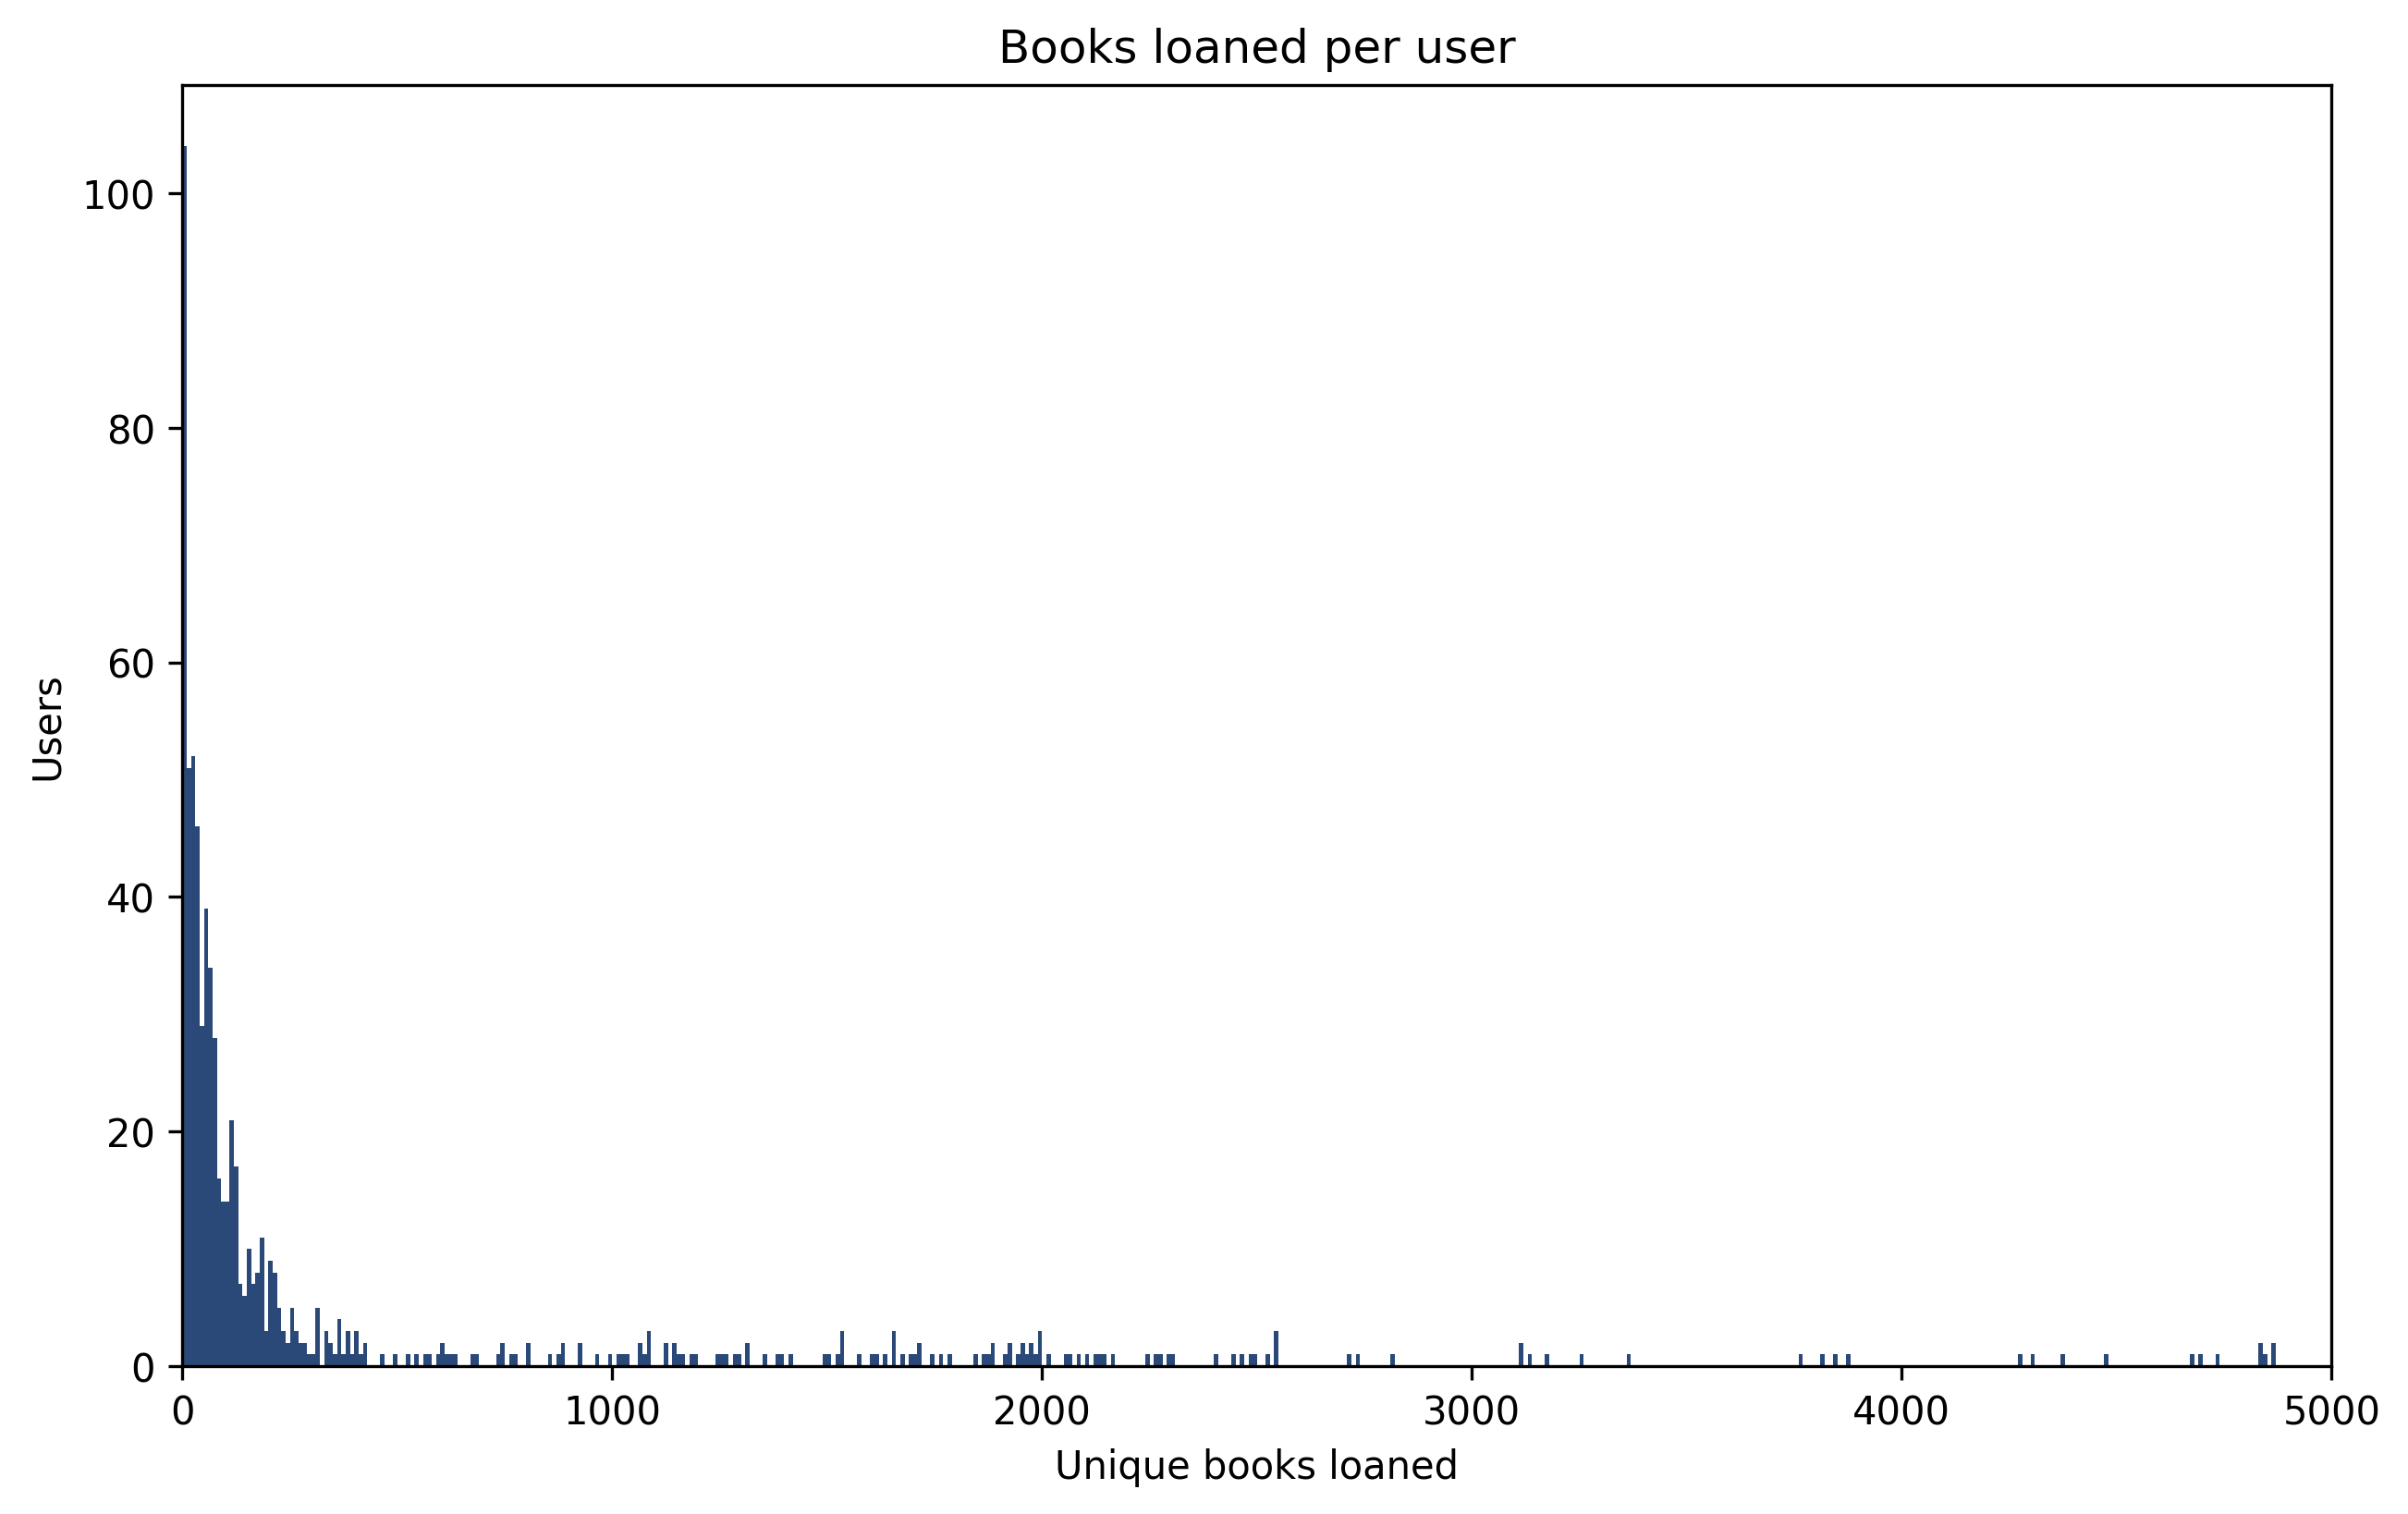

In [21]:
user_book_counts = user_df.groupby('Z36H_ID')['Z30_CALL_NO'].nunique()

# Create a bar plot
plt.figure(figsize=(10, 6), dpi=300)
bins = np.arange(0, user_book_counts.max()+ 1, 10)
plt.hist(user_book_counts, bins=bins, color='#2A4978')
plt.title('Books loaned per user')
plt.xlabel('Unique books loaned')
plt.ylabel('Users') # Set the y-axis limits
plt.xlim(0, 5000)  # Set the x-axis limits
plt.show()

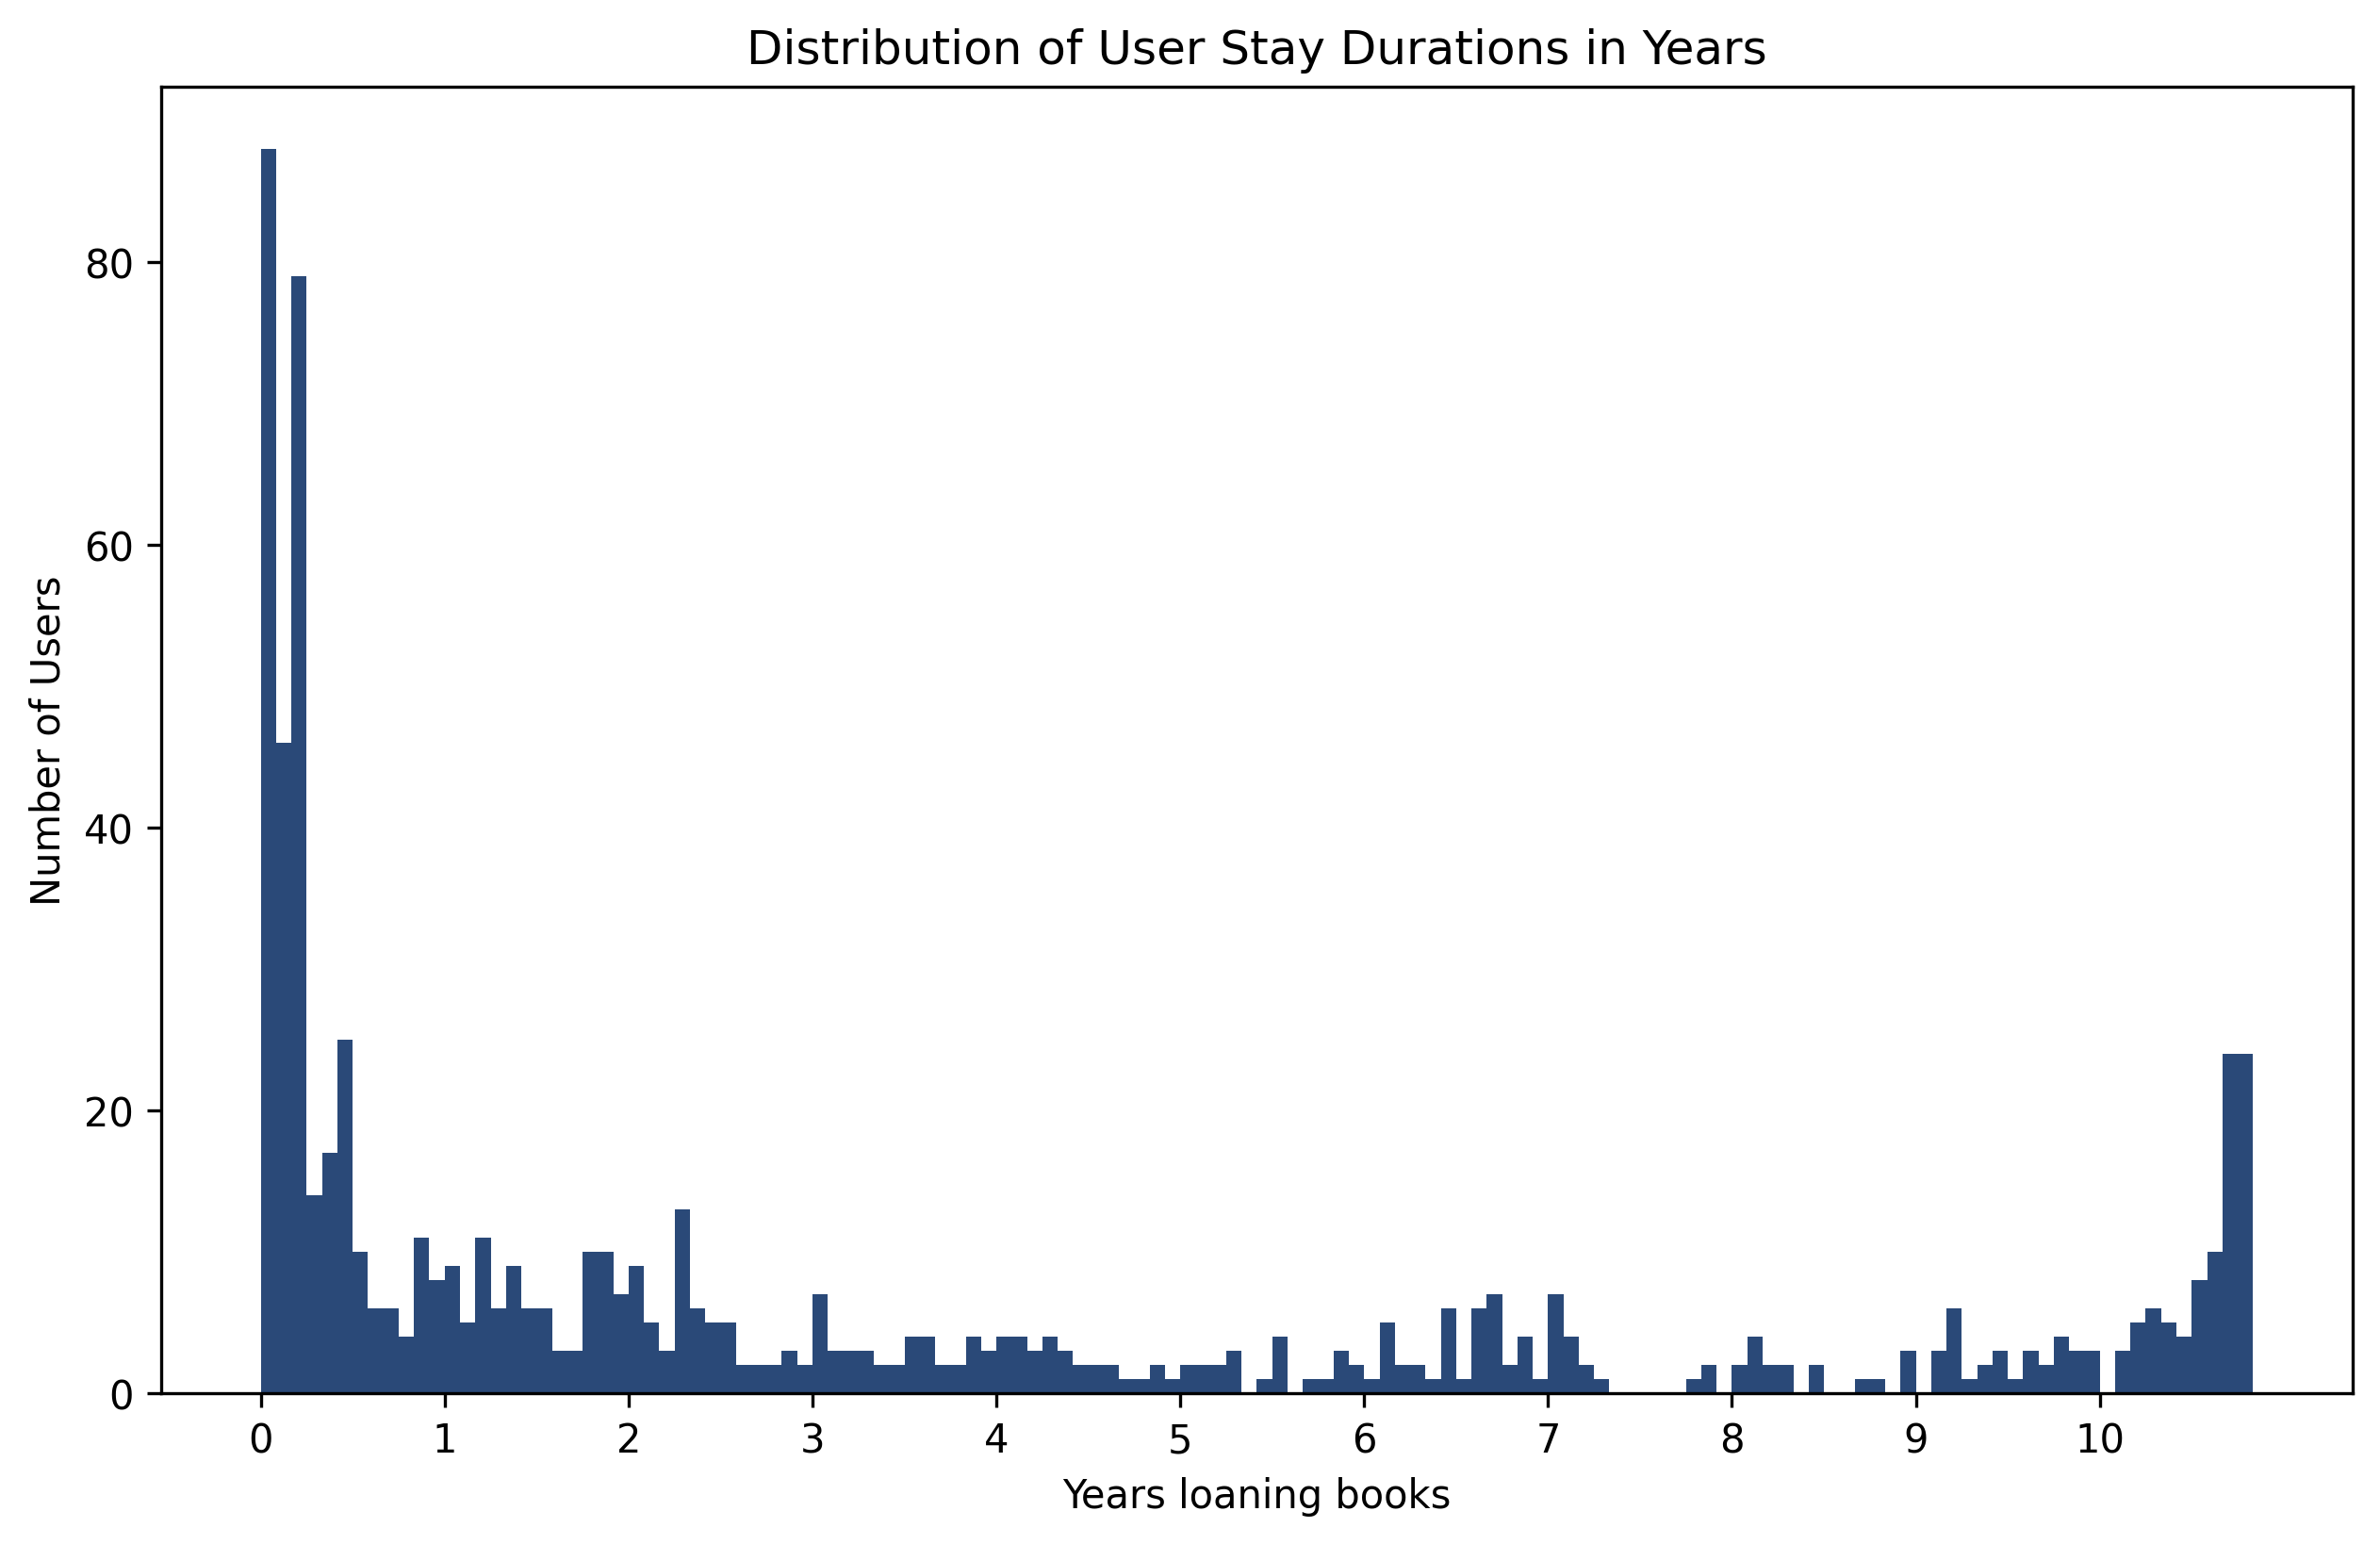

In [22]:
# Calculate the first and last loan dates for each user
user_first_loan_date = user_df.groupby('Z36H_ID')['Z36H_LOAN_DATE'].min()
user_last_loan_date = user_df.groupby('Z36H_ID')['Z36H_LOAN_DATE'].max()

# Calculate the duration of stay in the library for each user in years
user_stay_duration_months = (user_last_loan_date - user_first_loan_date).dt.days // 30 

plt.figure(figsize=(10, 6), dpi=300)
bins = np.arange(0, user_stay_duration_months.max()+ 1, 1)
plt.hist(user_stay_duration_months, bins=bins, color='#2A4978')
plt.title('Distribution of User Stay Durations in Years')
plt.xlabel('Years loaning books')
plt.ylabel('Number of Users')

x_ticks = np.arange(0, (user_stay_duration_months.max() + 1), 12)
plt.xticks(x_ticks, x_ticks // 12)

plt.show()

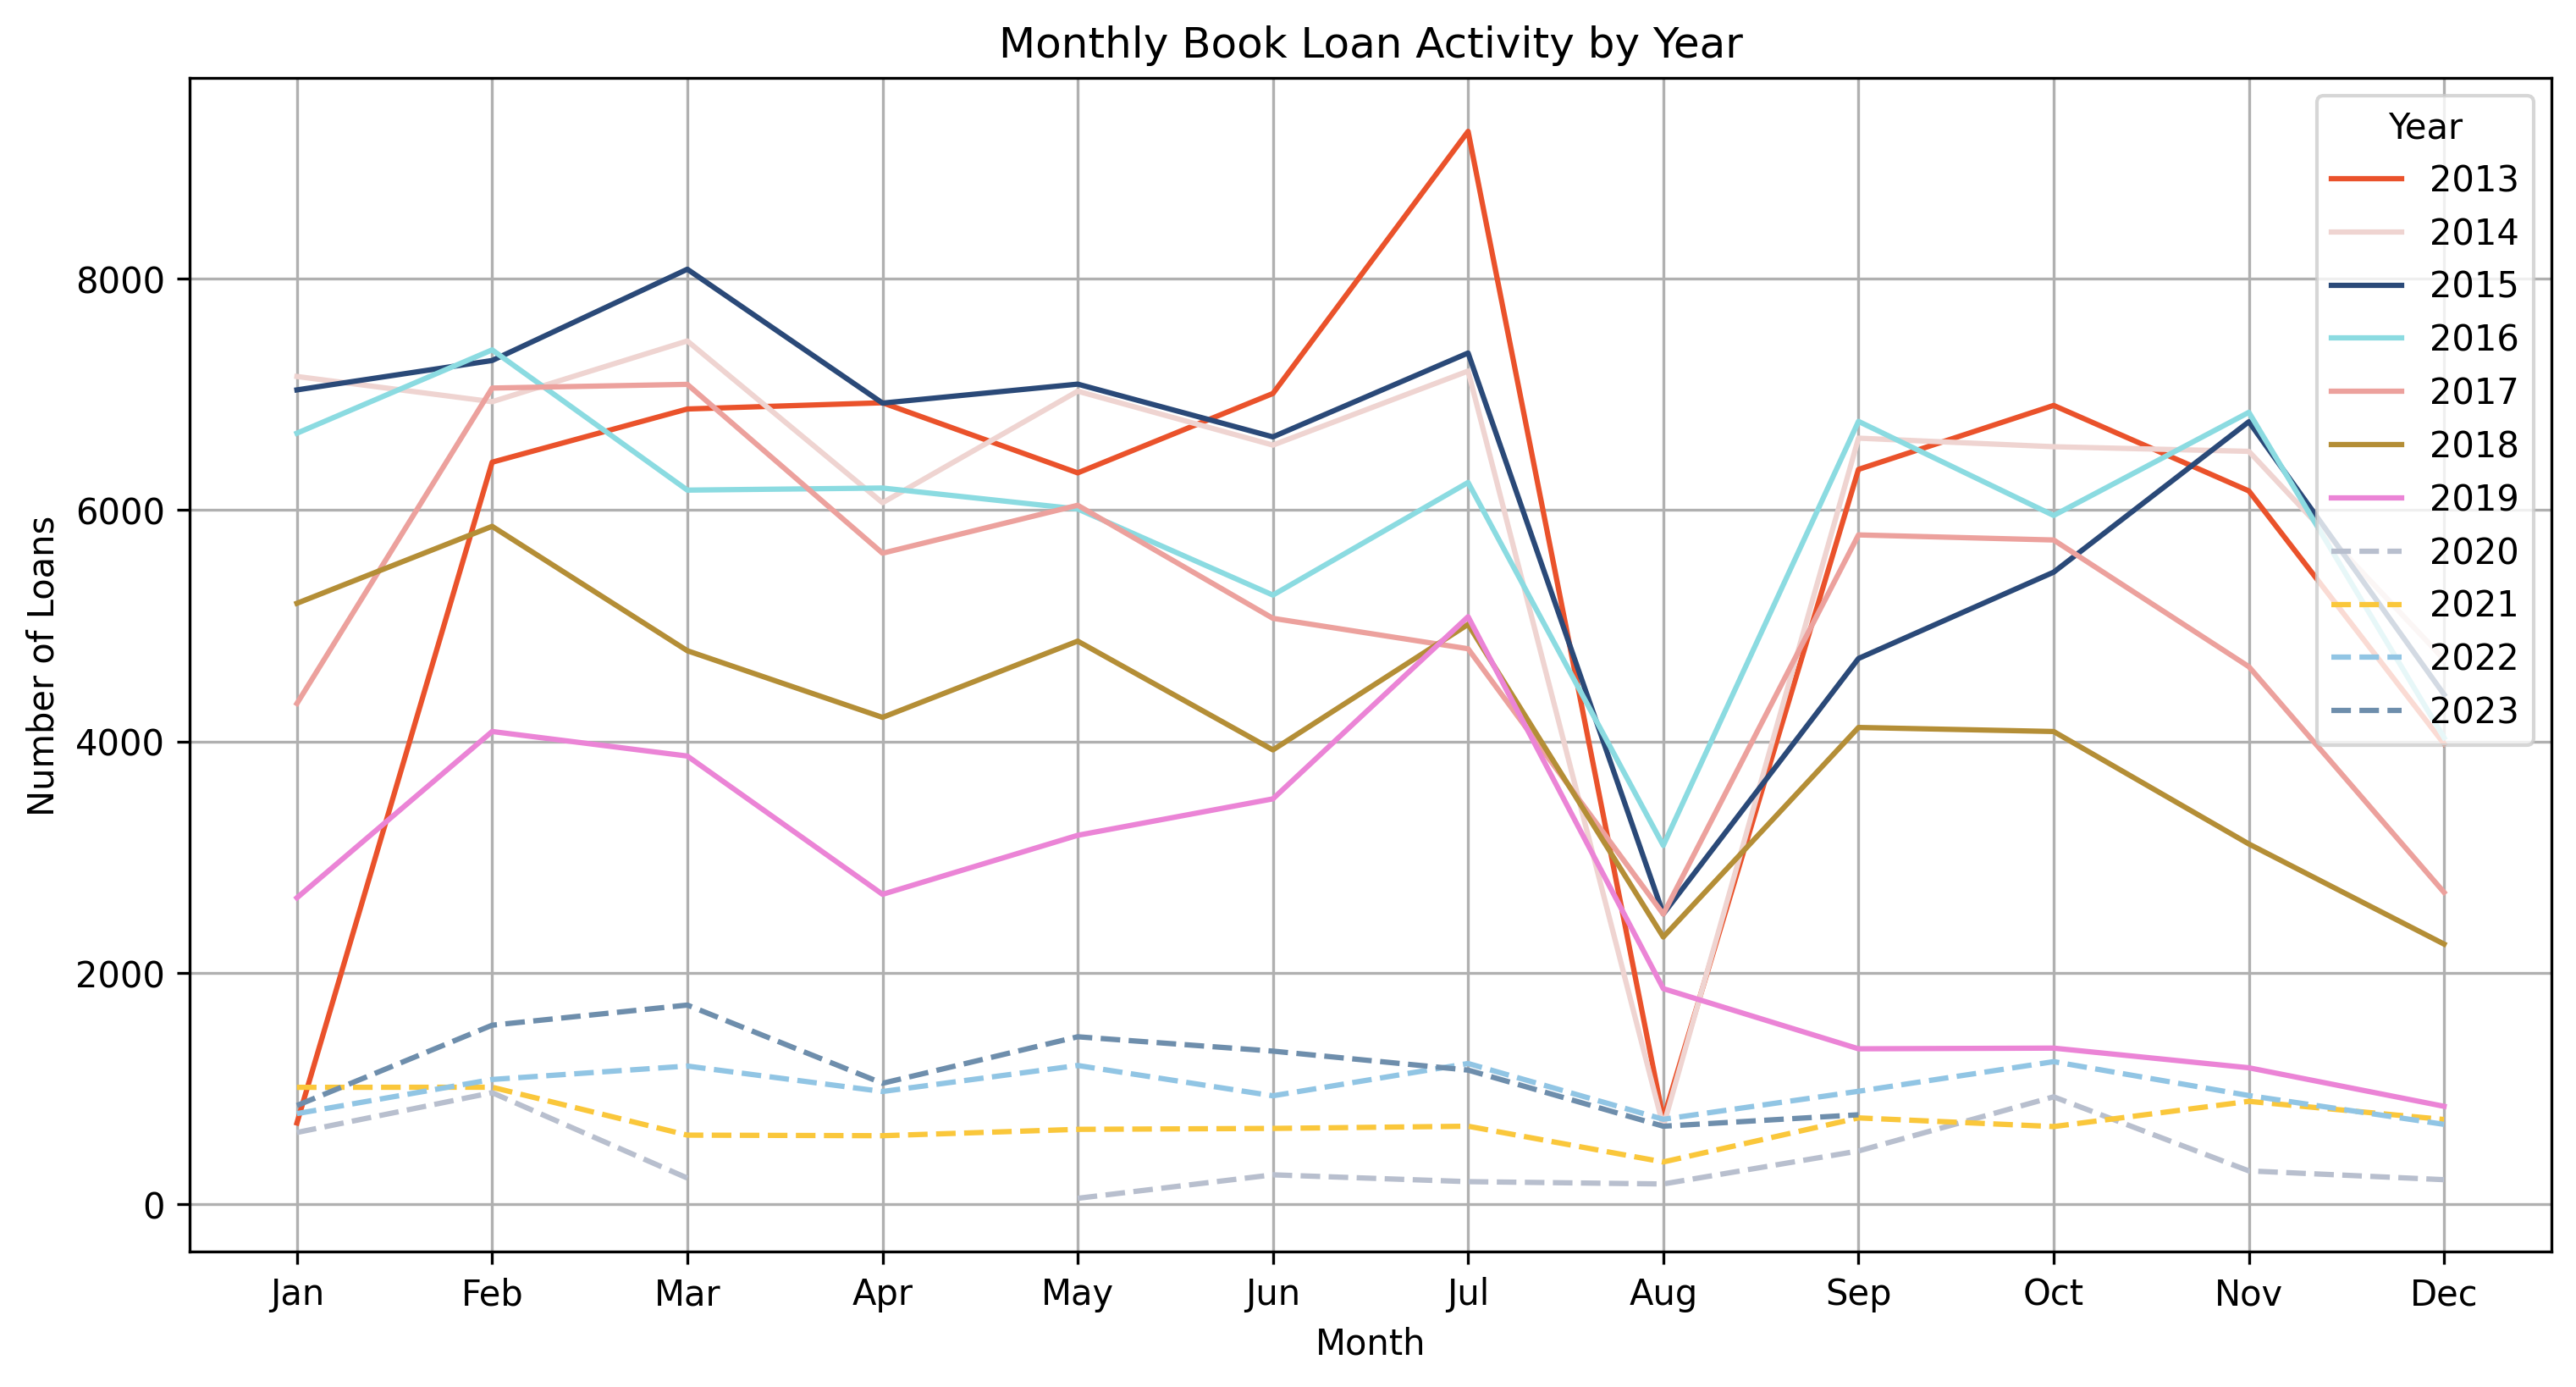

In [23]:

# Map books over time (e.g. a year, when is the library most active, when not so much)
loan_counts = user_df.groupby(['Year', user_df['Z36H_LOAN_DATE'].dt.month])['Z30_CALL_NO'].count().unstack()

# Create a line plot for each year with conditional line styles
plt.figure(figsize=(12, 6), dpi=300)
sns.set_palette(custom_colours)
for year in loan_counts.index:
    linestyle = '-' if year <= 2019 else '--'  # Dotted line for years after 2019
    plt.plot(loan_counts.columns, loan_counts.loc[year], label=f'{year}', linestyle=linestyle)

plt.title('Monthly Book Loan Activity by Year')
plt.xlabel('Month')
plt.ylabel('Number of Loans')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year', loc='upper right')
plt.show()

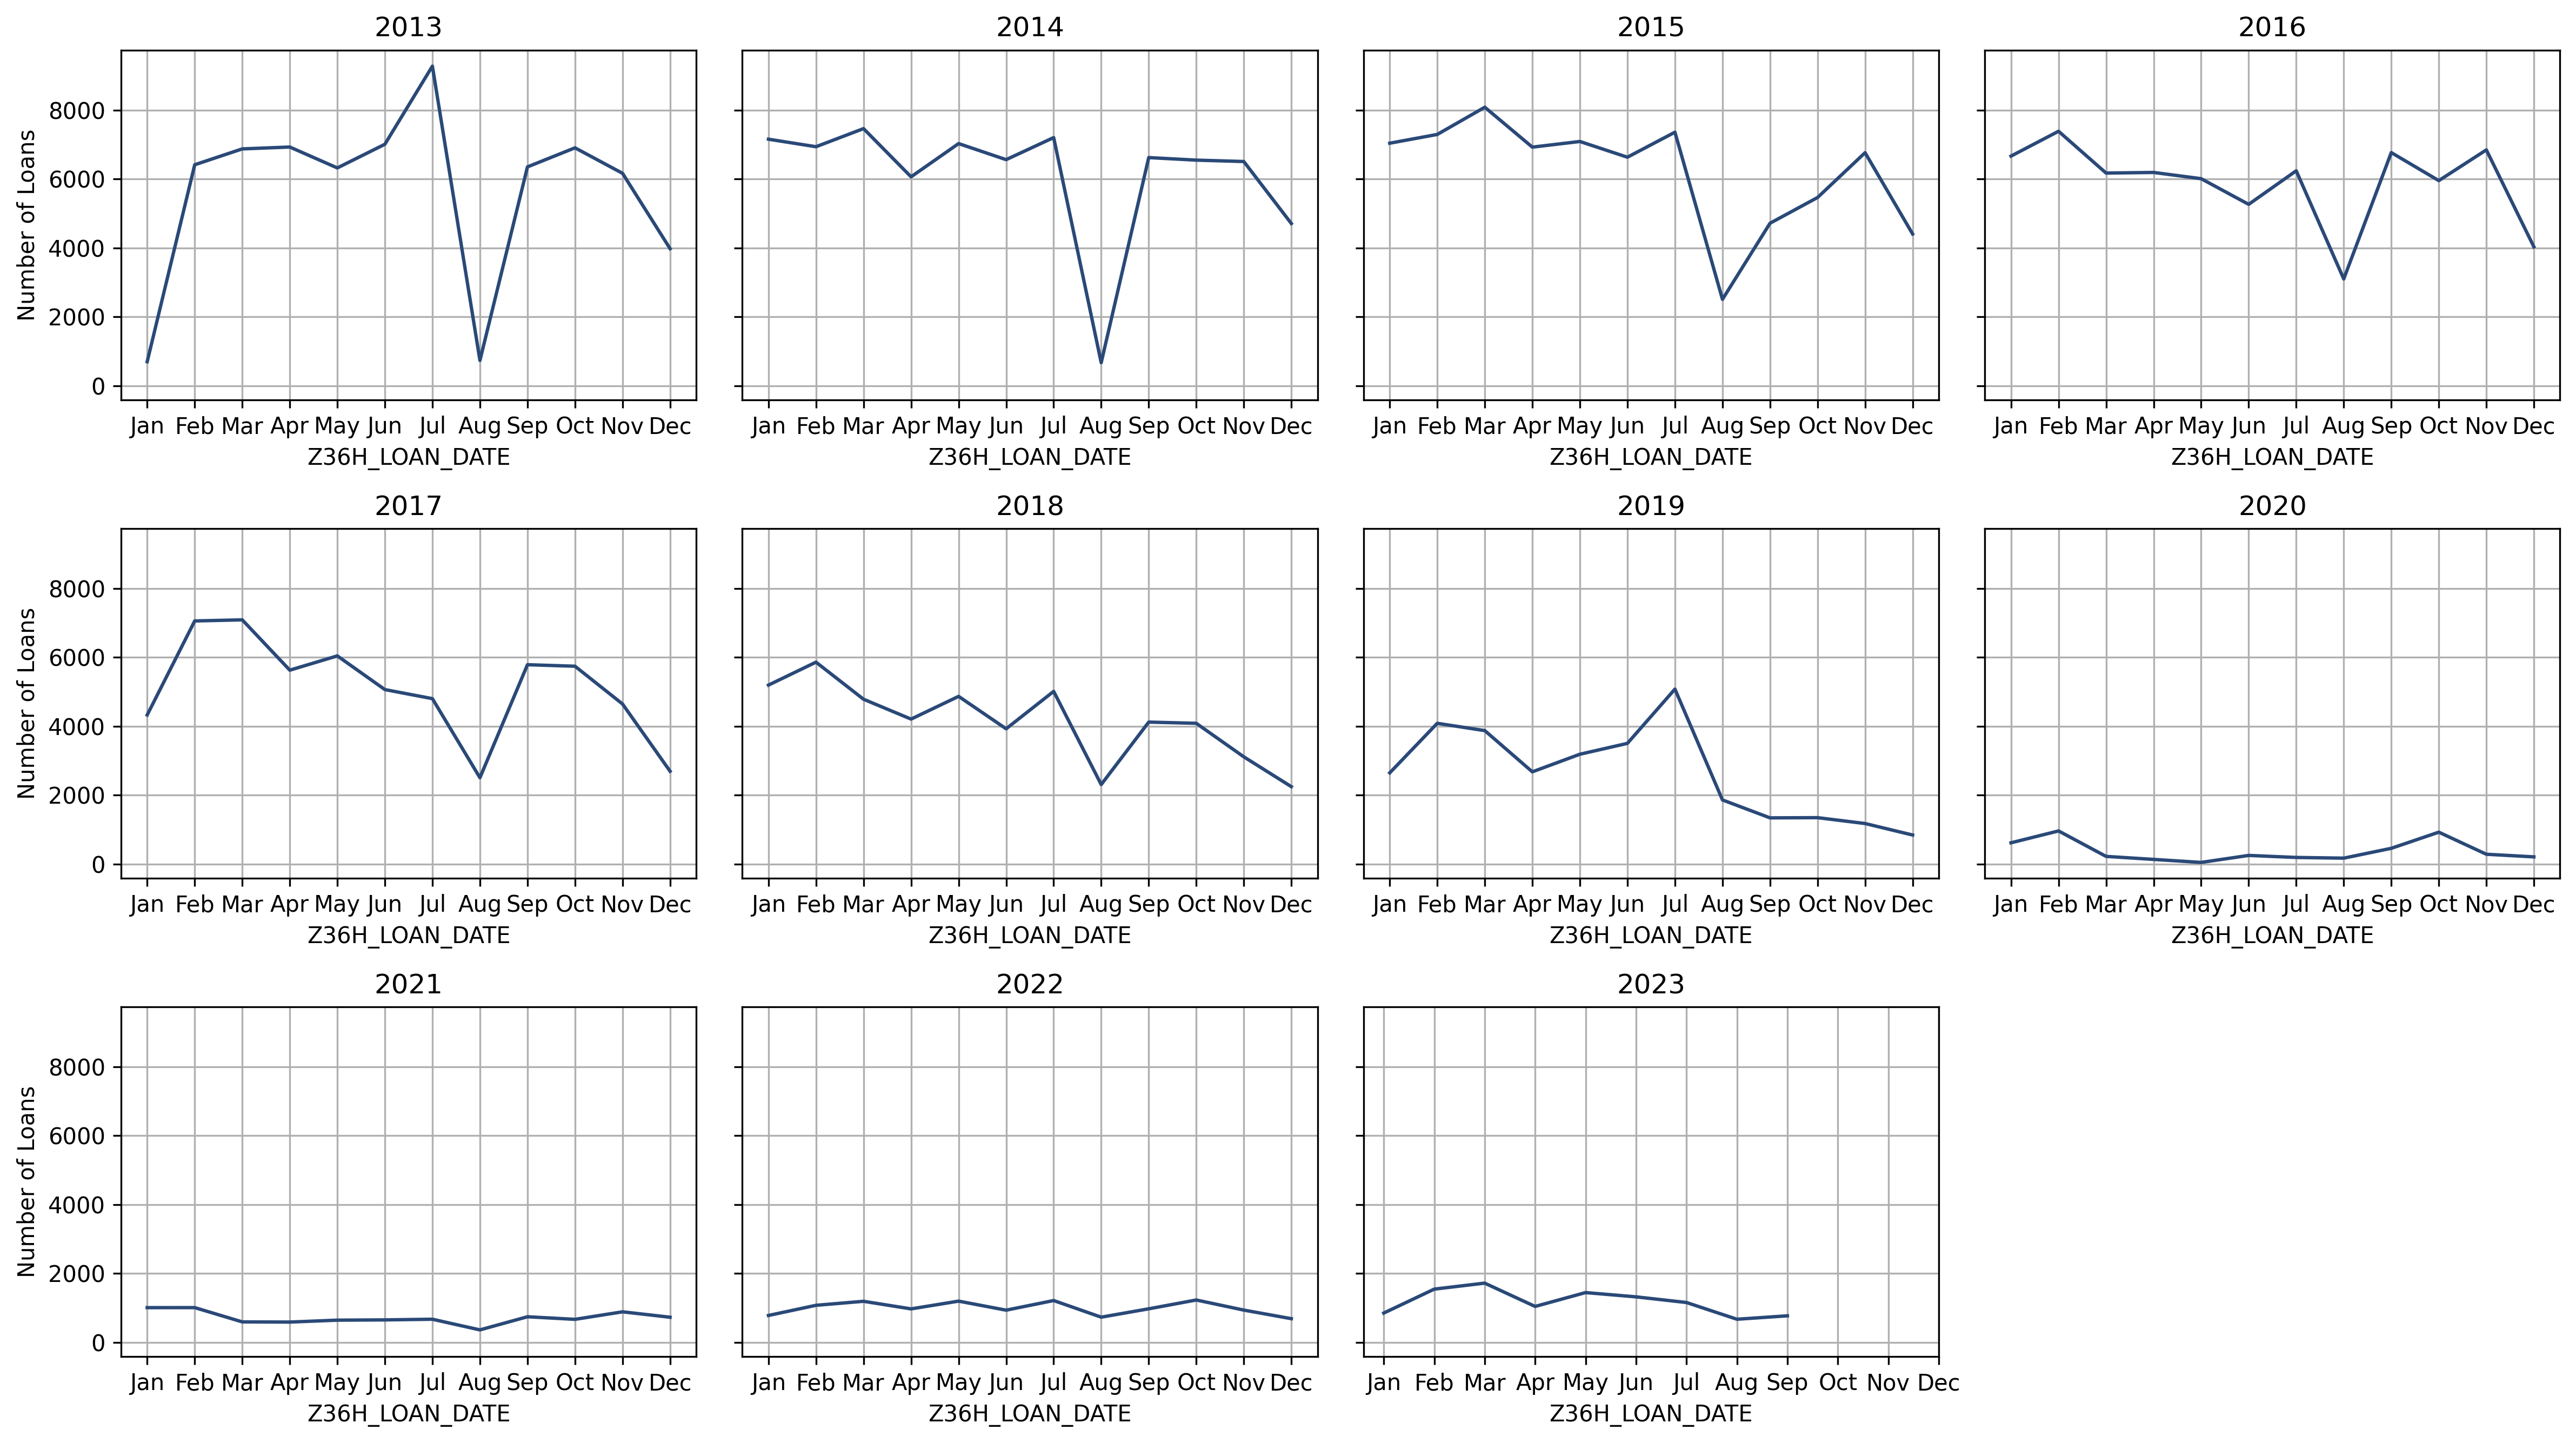

In [24]:
loan_counts = user_df.groupby([user_df['Z36H_LOAN_DATE'].dt.year, user_df['Z36H_LOAN_DATE'].dt.month]).Z30_CALL_NO.count()

unique_years = user_df.Z36H_LOAN_DATE.dt.year.unique()
num_rows = (len(unique_years) - 1) // 4 + 1 # subplots
unique_years.sort()
fig, axes = plt.subplots(num_rows, 4, figsize=(16, 3 * num_rows), sharey=True, dpi= 300)  # Share the y-axis limit

for i, year in enumerate(unique_years):
    row, col = i // 4, i % 4
    ax = axes[row, col]

    data_year = loan_counts.loc[year].reset_index()

    # Create line plots for internal and external users
    sns.lineplot(data=data_year, x='Z36H_LOAN_DATE', y='Z30_CALL_NO', ax=ax, color='#2A4978')

    ax.set_title(f'{year}')
    ax.set_ylabel('Number of Loans')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax.grid(True)

# Hide empty subplots
for i in range(len(unique_years), num_rows * 4):
    row, col = i // 4, i % 4
    fig.delaxes(axes[row, col])

# To ensure proper spacing
plt.tight_layout()
plt.show()

# TODO: split years into pre and post covid



# Dataframes pre and post 2019

In [35]:
pre_user = user_df[user_df.Year <= 2019]
post_user = user_df[user_df.Year > 2019]

In [36]:
def print_dataset_stats(df, name): 
    print('-----------------------------------------------------')
    print(name)
    print('Unique books in dataset: {}'.format( df.Z30_CALL_NO.unique().size))
    print(f'Number of loans in total: {len(df)}')
    total_users = df.Z36H_ID.unique().size
    print('Unique users in dataset: {}'.format(total_users))
    print('-----------------------------------------------------')


print_dataset_stats(pre_user, 'Pre change in policy')
print_dataset_stats(post_user, 'Post change in policy')


-----------------------------------------------------
Pre change in policy
Unique books in dataset: 88633
Number of loans in total: 428858
Unique users in dataset: 551
-----------------------------------------------------
-----------------------------------------------------
Post change in policy
Unique books in dataset: 18354
Number of loans in total: 35502
Unique users in dataset: 405
-----------------------------------------------------


In [47]:
def process_book_df(user_df):

    # Grouping by Book Call number
    grouped = user_df.groupby('Z30_CALL_NO')

    # Total times loaned
    frequency = grouped['Z36H_ID'].count()
    title = grouped['Z13_TITLE'].unique().apply(lambda x: x[0])

    # Unique users who loaned the book
    users = grouped['Z36H_ID'].unique().apply(list)

    # Users weighed on how many times the user loaned the book
    user_book_counts = user_df.groupby(['Z36H_ID', 'Z30_CALL_NO']).size().reset_index(name='COUNT')
    users_weighed = user_book_counts.groupby('Z30_CALL_NO').apply(lambda x: [user for user, count in zip(x['Z36H_ID'], x['COUNT']) for _ in range(count)])

    # Users weighed by loantime (appearing in list as many times as book was loaned in days)
    # users_weighed = grouped.apply(lambda x: sum([[user] * int(days) for user, days in zip(x['Z36H_ID'], x['LOAN_TIME'])], []))

    # Frequency of loan over the years
    years_freq = grouped['Year'].value_counts().reset_index().groupby('Z30_CALL_NO').apply(lambda group: dict(zip(group['Year'], group['count'])))

    # Total time per year (in days) book was loaned
    years_loan_time = user_df.groupby(['Z30_CALL_NO', user_df['Z36H_LOAN_DATE'].dt.year])['LOAN_TIME'].sum().reset_index()
    years_loan_time = years_loan_time.groupby('Z30_CALL_NO').apply(lambda group: dict(zip(group['Z36H_LOAN_DATE'], group['LOAN_TIME'])))

    # Create the output DataFrame
    output_df = pd.DataFrame({
        'frequency': frequency,
        'users': users,
        'users_weighed': users_weighed,
        'yearly_frequency': years_freq,
        'yearly_loan_time': years_loan_time,
        'title': title
    })
    output_df.reset_index(inplace=True)

    # Determine and drop outliers based on frequency threshold
    threshold = 500 # Anything above this value is most probably several editions of the same journal
    output_df['is_outlier'] = output_df['frequency'].apply(lambda x: True if x > threshold else False)
    output_df = output_df[~output_df['is_outlier']].reset_index(drop=True)

    # Yearly frequency normed
    years_df = pd.DataFrame(output_df['yearly_frequency'].tolist()).fillna(0)
    scaler = MinMaxScaler()
    normalized_years_df = pd.DataFrame(scaler.fit_transform(years_df), columns=years_df.columns)
    output_df['yearly_frequency_norm'] = normalized_years_df.apply(lambda x: {year: x[year] for year in years_df.columns}, axis=1)

    # Frequency total normed
    frequency = output_df['frequency'].to_numpy().reshape(-1, 1)
    scaler = MinMaxScaler()
    frequency_scaled = scaler.fit_transform(frequency)
    output_df['frequency_norm'] = frequency_scaled



    return output_df

pre = process_book_df(pre_user)
post = process_book_df(post_user)
full = process_book_df(user_df)

In [48]:
pre.to_csv('exp/pre.csv',index=False)
post.to_csv('exp/post.csv',index=False)
full.to_csv('exp/full.csv',index=False)

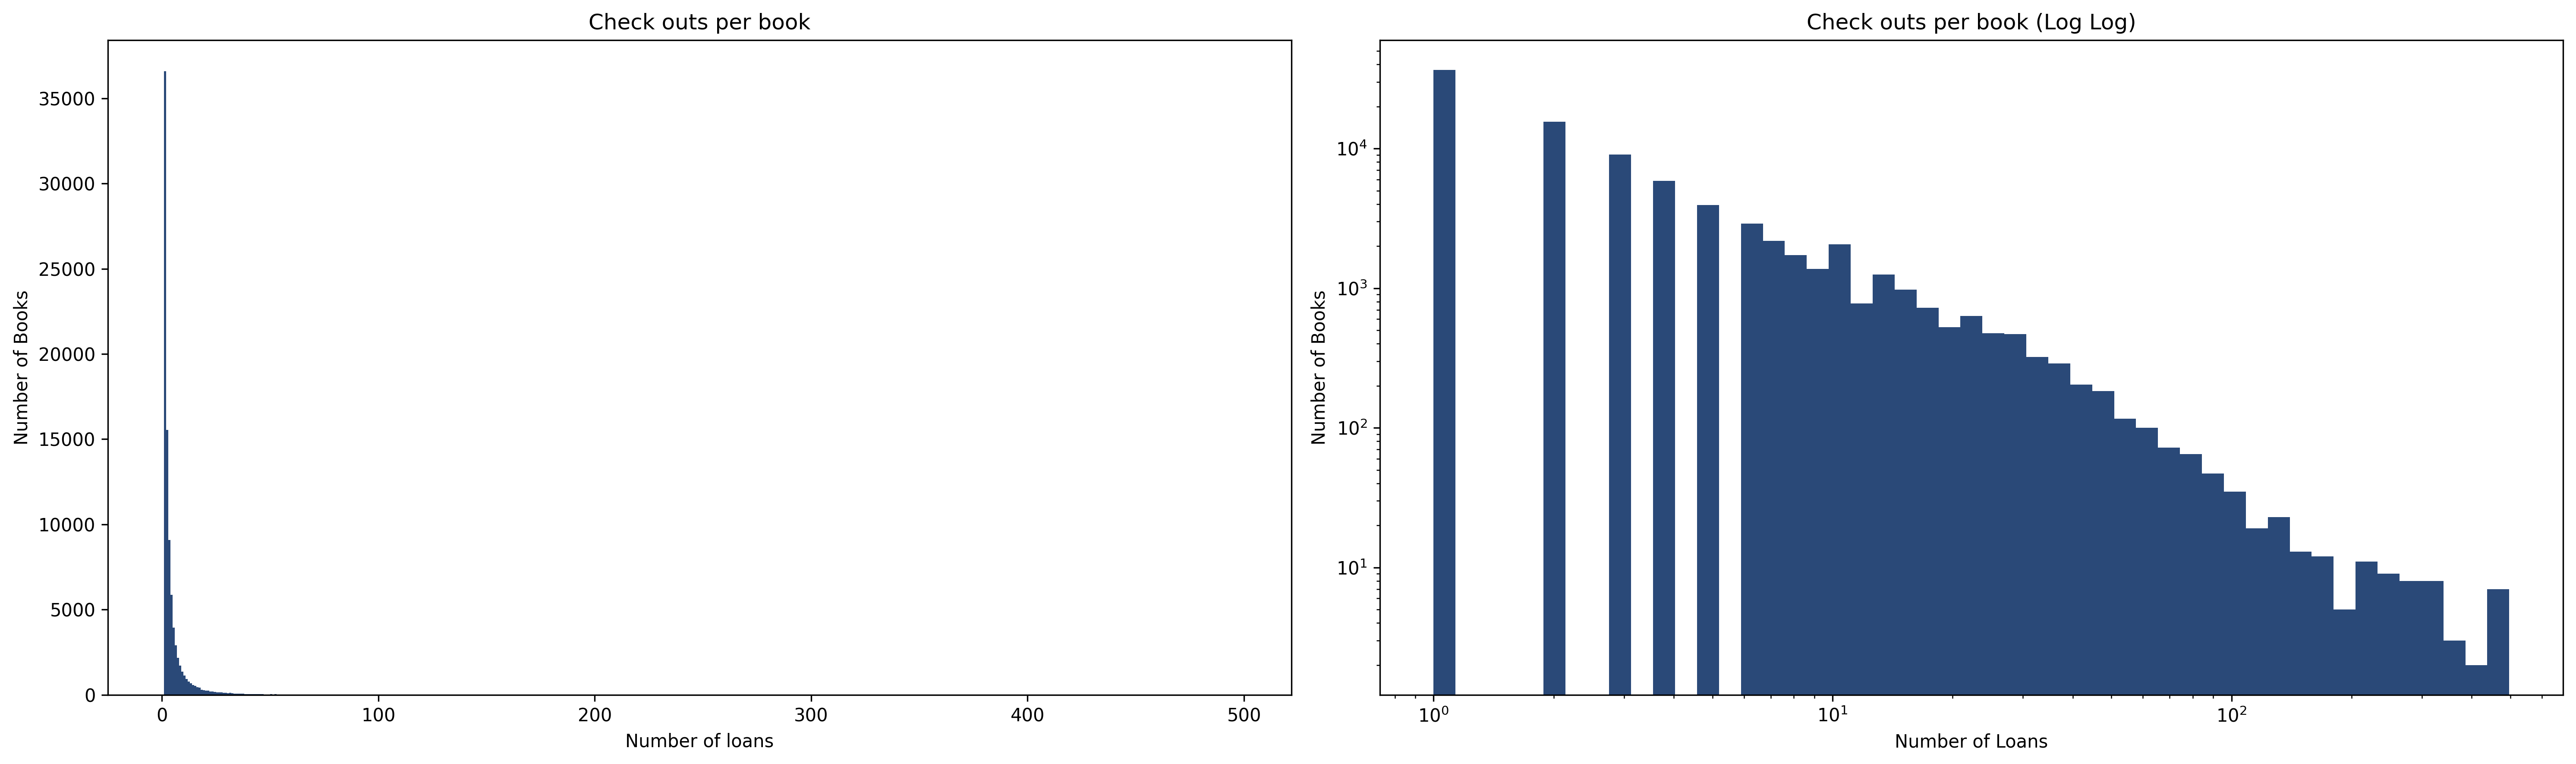

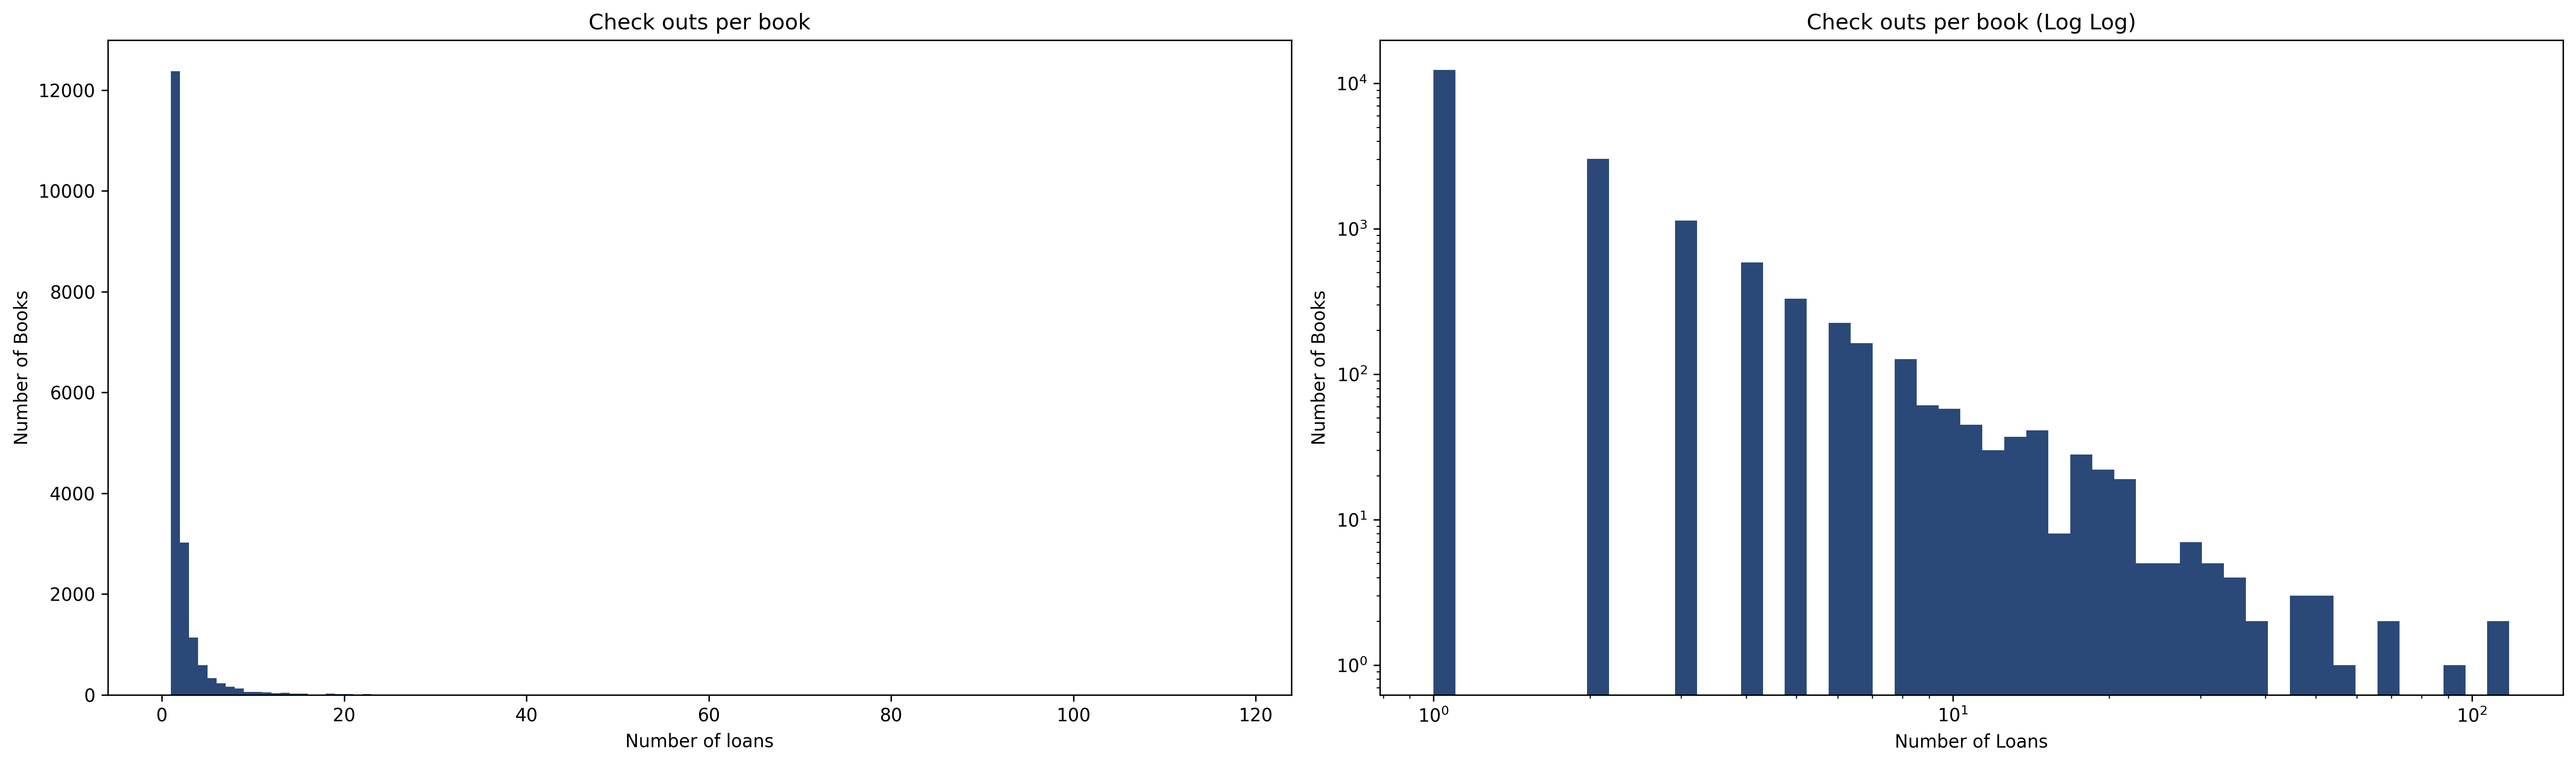

In [49]:
def plot_loan_frequency(df):
    
    max_frequency = df.frequency.max()
    bins = np.arange(0, max_frequency + 1, 1)
    logbins = 10 ** np.linspace(np.log10(df.frequency.min()), np.log10(max_frequency), 50)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6), dpi=300)

    # Regular Histogram
    ax1.hist(df.frequency, bins=bins, color='#2A4978')
    ax1.set_title('Check outs per book')
    ax1.set_xlabel('Number of loans')
    ax1.set_ylabel('Number of Books')

    # Log Log Plot
    ax2.hist(df.frequency, bins=logbins, color='#2A4978', log=True)
    ax2.set_title('Check outs per book (Log Log)')
    ax2.set_xlabel('Number of Loans')
    ax2.set_ylabel('Number of Books')
    ax2.set_xscale('log')

    plt.tight_layout()
    plt.show()

plot_loan_frequency(pre)
plot_loan_frequency(post)